# Loading Covid data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import re
import sys
import time
import yaml
import dateutil.parser
from datetime import date, datetime, timedelta
from pprint import pprint as pp
import numpy as np
import pandas as pd

from pyathena import connect
from elasticsearch import Elasticsearch

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import matplotlib.dates as mdates
import zipfile

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sys.path.insert(0, r'..')

In [2]:
from src.config import DATA_FOLDER

In [3]:
GLOBAL_CONF = 'global-src-confirmed.csv'
GLOBAL_DEAD = 'global-src-deaths.csv'
GLOBAL_REC = 'global-src-recovered.csv'

In [4]:
df_glo_conf = pd.read_csv(DATA_FOLDER.joinpath(GLOBAL_CONF))
df_glo_dead = pd.read_csv(DATA_FOLDER.joinpath(GLOBAL_DEAD))
df_glo_rec = pd.read_csv(DATA_FOLDER.joinpath(GLOBAL_REC))

print(f"Confirmed shape: {df_glo_conf.shape}")
print(f"Dead shape: {df_glo_dead.shape}")
print(f"Recovered shape: {df_glo_rec.shape}")

Confirmed shape: (256, 75)
Dead shape: (256, 75)
Recovered shape: (242, 75)


In [5]:
df_glo_conf.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,40,74,84,94,110,110,120,170,174,237
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,104,123,146,174,186,197,212,223,243,259
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,230,264,302,367,409,454,511,584,716,847
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,133,164,188,224,267,308,334,370,376,390
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,3,3,3,4,4,5,7,7,7,8
5,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,3,3,3,7,7,7,7,7,7,7
6,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,...,301,387,387,502,589,690,745,820,1054,1054
7,NaN,Armenia,40.0691,45.0382,0,0,0,0,0,0,...,235,249,265,290,329,407,424,482,532,571
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,32,39,39,53,62,71,77,78,80,84
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,669,818,1029,1219,1405,1617,1791,2032,2032,2182


In [6]:
is_date = re.compile(r'[\d]{1,2}/[\d]{1,2}/[\d]{1,4}')
date_columns = [k for k in df_glo_conf.columns if is_date.match(k)]
columns2extract = ['Country/Region', *date_columns]
print(f"Columns selected: {columns2extract[:2]} ...")

Columns selected: ['Country/Region', '1/22/20'] ...


In [7]:
updated_indexes = [dateutil.parser.parse(k) for k in date_columns]

In [8]:
df_global_confirmed = df_glo_conf.loc[:, columns2extract].groupby('Country/Region').sum().transpose()
df_global_dead = df_glo_dead.loc[:, columns2extract].groupby('Country/Region').sum().transpose()
df_global_recovered = df_glo_rec.loc[:, columns2extract].groupby('Country/Region').sum().transpose()

In [9]:
df_global_confirmed.index = updated_indexes
df_global_dead.index = updated_indexes
df_global_recovered.index = updated_indexes

In [10]:
df_global_confirmed.tail(3)

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
2020-03-30,170,223,584,370,7,7,820,482,4361,9618,...,548,611,22453,310,149,135,203,116,35,7
2020-03-31,174,243,716,376,7,7,1054,532,4559,10180,...,645,664,25481,338,172,135,212,119,35,8
2020-04-01,237,259,847,390,8,7,1054,571,4862,10711,...,794,814,29865,338,181,143,218,134,36,8


In [11]:
global_dict = {
    'confirmed': df_global_confirmed,
    'dead': df_global_dead,
    'recovered': df_global_recovered,
}

In [12]:
countries_list = global_dict['confirmed'].columns

In [13]:
def get_country_from_dict(data_dict, country='Spain'):
    sections = ['confirmed', 'dead', 'recovered']
    
    data_country = {}
    for section in sections:
        selection = data_dict[section].loc[:, country]
        selection.name = section
        data_country[section] = selection
    
    return pd.concat(data_country.values(), axis=1)

In [14]:
# Load widgets
from ipywidgets import *

In [15]:
@interact(country='Spain')
def country_plot(country=countries_list):
    
    df = get_country_from_dict(global_dict, country)
    
    fig, ax = plt.subplots(figsize=(16, 8), ncols=1)
    ax.plot('confirmed', data=df, marker='', color='blue', linewidth=2, linestyle='dashed', label="Confirmed")
    ax.plot('dead', data=df, marker='', color='red', linewidth=2, label="Dead")
    ax.plot('recovered', data=df, marker='', color='olive', linewidth=2, label="Recovered")
    ax.grid(color='grey', linestyle='-', linewidth=0.5)
    ax.tick_params(axis='x', rotation=65)

    ax.legend()
    ax.set_title(country, fontsize=20);

interactive(children=(Text(value='Spain', description='country'), Output()), _dom_classes=('widget-interact',)…

In [16]:
@interact(country='Spain')
def country_plot(country=countries_list):
    
    df = get_country_from_dict(global_dict, country)
    # Get the new cases per day
    df = df.diff(1)
    
    column = [('confirmed', 'blue'), ('dead', 'red'), ('recovered', 'green')]
    fig, ax = plt.subplots(figsize=(16, 4), ncols=3)     # , sharey='all'
    
    for idx, x in enumerate(ax):
        x.bar(df.index, df[column[idx][0]], color=column[idx][1])
        x.grid(color='grey', linestyle='-', linewidth=0.5)
        x.set_title(f"{country} {column[idx][0]}", fontsize=14);
        x.tick_params(axis='x', rotation=65)
        x.set_xlabel("Date")

interactive(children=(Text(value='Spain', description='country'), Output()), _dom_classes=('widget-interact',)…

## Progression from +n cases

In [17]:
# Set parameters
TOP_SELECTED = 10

# Retrieve countries with top number of confirmed cases:
top_countries = global_dict['confirmed'].iloc[-1, :].sort_values(ascending=False)[:TOP_SELECTED].index

# Retrieve data for those countries
df_top_confirmed = df_global_confirmed.loc[:, top_countries]

In [18]:
# Normalize starting point as per selected threshold
def normalize_data(df, threshold=50, margin=25):
    max_day = 0
    processing = {}
    recompute = []
    
    for country in df.columns:
        processing[country] = df[country][df[country] >= threshold]
        if processing[country][0] >= threshold * 2:
            recompute.append(country)

        new_index = np.arange(len(processing[country].index))
        processing[country].index = new_index
        if new_index[-1] > max_day:
            max_day = new_index[-1]

    if recompute:
        # Adjust series that may have missing values or start for a very high number
        countries_within_threshold = [c for c in df.columns if c not in recompute]
        df_top = pd.concat(processing.values(), axis=1)

        for r in recompute:
            find_point = processing[r][0]
            m = (df_top[countries_within_threshold] > find_point - margin) | \
                (df_top[countries_within_threshold] > find_point + margin)
            initial_row = m.sum(axis=1).to_numpy().nonzero()[0][0]
            processing[r].index = np.arange(initial_row, len(processing[r].index) + initial_row)

    return pd.concat(processing.values(), axis=1)

#### Progression from +50 cases

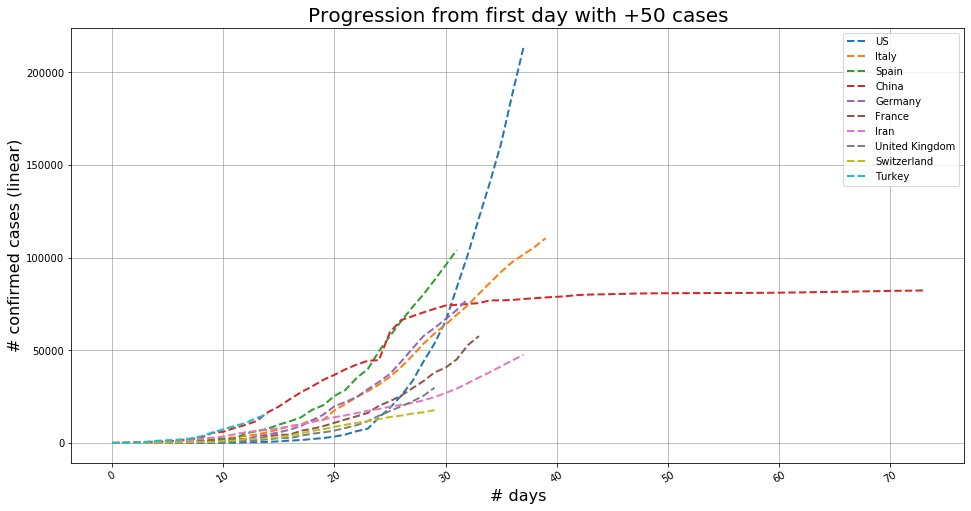

In [24]:
THRESHOLD = 50
df_normalized_50 = normalize_data(df_top_confirmed, threshold=THRESHOLD, margin=25)

fig, ax = plt.subplots(figsize=(16, 8), ncols=1)

for c in df_normalized_50.columns:
    ax.plot(c, data=df_normalized_50, marker='', linewidth=2, linestyle='dashed', label=c)
    
ax.grid(color='grey', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', rotation=30)
ax.set_xlabel('# days', fontsize=16)
ax.set_ylabel('# confirmed cases (linear)', fontsize=16)
ax.legend()
ax.set_title(f"Progression from first day with +{THRESHOLD} cases", fontsize=20);

NameError: name 'THRESHOLD' is not defined

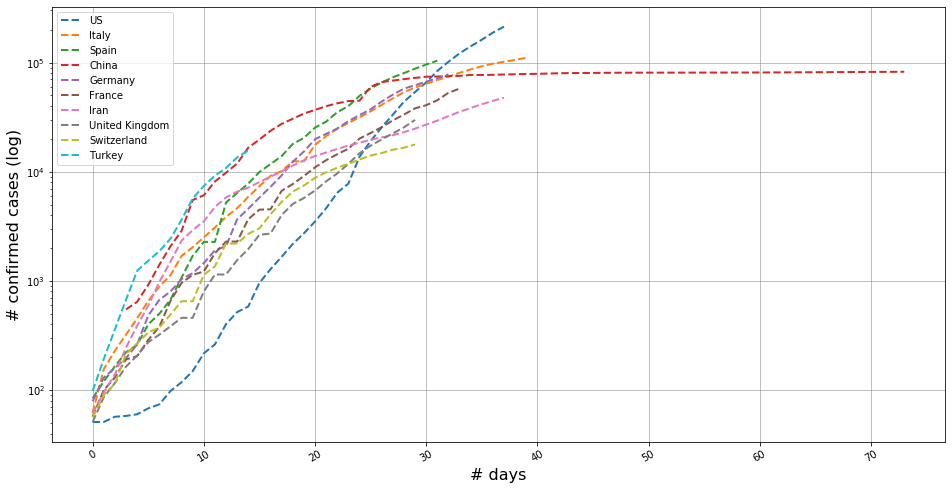

In [23]:
# Ploting Y with logaritmic scale to observe the beginning...

fig, ax = plt.subplots(figsize=(16, 8), ncols=1)

for c in df_normalized_50.columns:
    ax.plot(c, data=df_normalized_50, marker='', linewidth=2, linestyle='dashed', label=c)
    
ax.grid(color='grey', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', rotation=30)
ax.set_yscale('log')
ax.set_xlabel('# days', fontsize=16)
ax.set_ylabel('# confirmed cases (log)', fontsize=16)
ax.legend()
ax.set_title(f"Progression from first day with +{THRESHOLD} cases", fontsize=20);

#### Progression from +200 cases

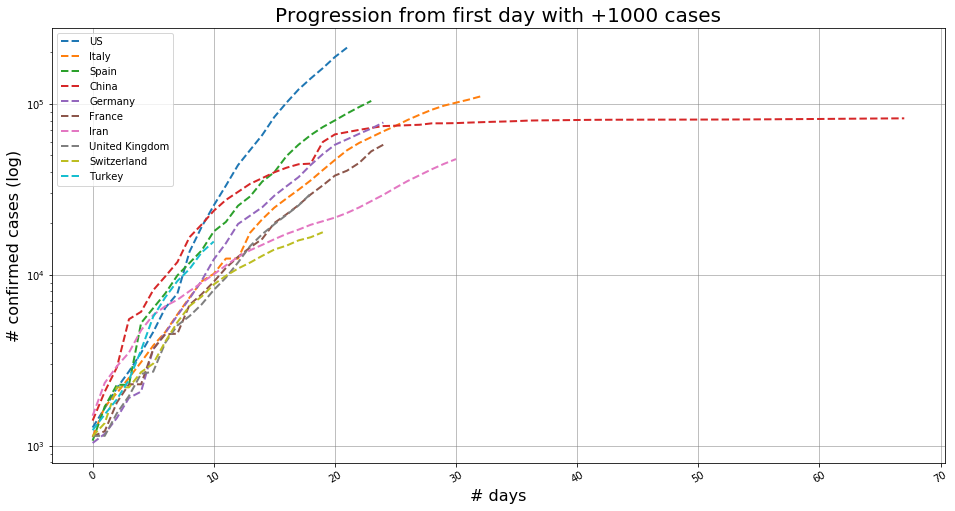

In [128]:
threshold = int(1e3)
df_normalized_1k = normalize_data(df_top_confirmed, threshold=threshold, margin=25)

fig, ax = plt.subplots(figsize=(16, 8), ncols=1)

for c in df_normalized.columns:
    ax.plot(c, data=df_normalized_1k, marker='', linewidth=2, linestyle='dashed', label=c)
ax.grid(color='grey', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', rotation=30)
ax.set_yscale('log')
ax.set_xlabel('# days', fontsize=16)
ax.set_ylabel('# confirmed cases (log)', fontsize=16)
ax.legend()
ax.set_title(f"Progression from first day with +{threshold} cases", fontsize=20);